In [1]:
#import  basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

#import classifier libraries
import sklearn as skl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import scikitplot as skplt


from sklearn.feature_extraction.text import CountVectorizer


import xgboost as xgb

#nlp libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from collections import Counter 

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)


[nltk_data] Downloading package punkt to /Users/michaelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Gathering Data

In [2]:
#Consolidating Data

#Read in training and test Json file from Yummly
df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')

In [3]:
#Read in Hawaiian Ingredients
with open('results_hawaiian_Main Dishes.json') as f:
    hawaiian = json.load(f)

In [4]:
hawaiian_recipe_list = [m['ingredients'] for m in hawaiian['matches']] #this is a list of all hawaiian ingredients

x = pd.Series(hawaiian_recipe_list) #if you convert it to series pandas will make it a single column
df_hawaiian = pd.DataFrame(x, columns = ['ingredients'])
df_hawaiian['cuisine'] = 'hawaiian' #create new cuisine column for hawaiian df
df_hawaiian= df_hawaiian[['cuisine', 'ingredients']] #reorder columns
df_hawaiian.head(3)

,cuisine,ingredients
0,hawaiian,"[pork chops, 1 inch thick, pineapple slices, s..."
1,hawaiian,"[pineapple chunks, juice, soy sauce, brown sug..."
2,hawaiian,"[bbq sauce, pineapple juice, lime juice, fresh..."


In [5]:
#drop id column from df_train
df_train.drop('id', axis = 1, inplace = True)
df_newtest = pd.concat([df_train, df_hawaiian])#concat dataframes together for complete recipe data frame

df_newtest.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
df_newtest['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
hawaiian         778
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

# 2. Initial EDA

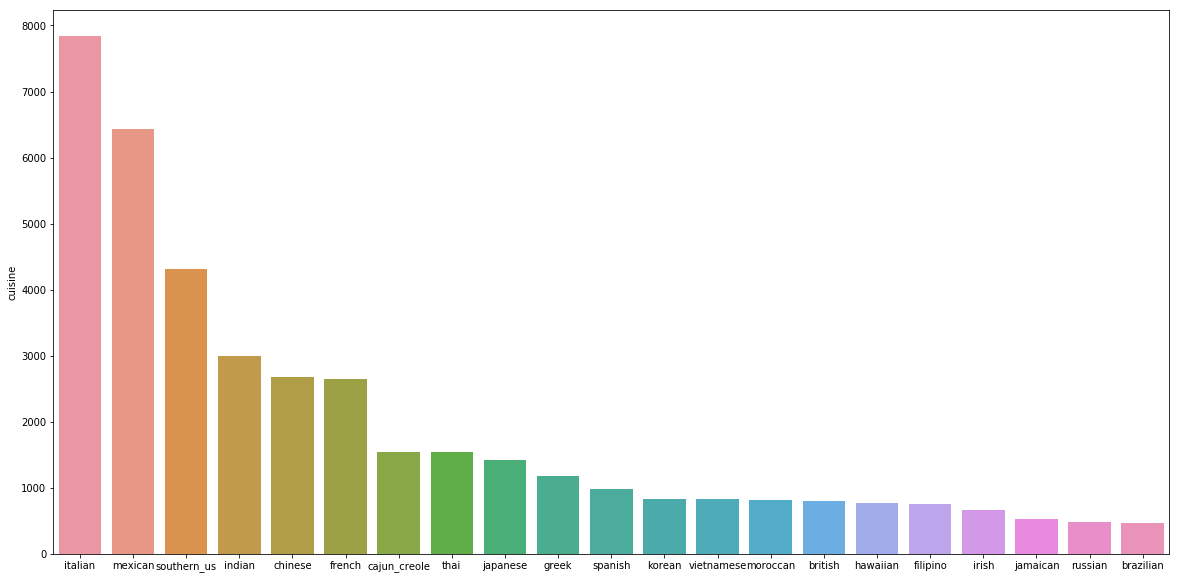

In [7]:
df_count_cuisine = pd.DataFrame(df_newtest.cuisine.value_counts())
plt.figure(figsize = (20,10))
sns.barplot(x = df_count_cuisine.index, y = df_count_cuisine.cuisine);

#Recipes are imbalanced, sample weights or oversampling may be needed

# 3. ML/NLP Prep

In [8]:
#make list of ingredients into a single string to be analyzed

ingredient_strings =[]

for ingredients in df_newtest['ingredients']:
    ingredients = ' '.join(ingredients)
    ingredient_strings.append(ingredients)


In [9]:
df_newtest['nlp_ingredients'] = ingredient_strings

df_newtest.head()

,cuisine,ingredients,nlp_ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


In [10]:
df_newtest.ingredients[20000]

['saffron threads',
 'quinces',
 'red currant jelly',
 'onions',
 'celery ribs',
 'vegetable oil',
 'dry red wine',
 'dried cranberries',
 'veal demi-glace',
 'lemon',
 'garlic cloves',
 'juniper berries',
 'cinnamon',
 'lamb shoulder']

In [11]:
#Regex to get rid of numbers so that only ingredients are left

#use an apply function to apply regrex to each row in nlp_ingredients


df_newtest['nlp_ingredients'] = df_newtest['nlp_ingredients'].apply(lambda x: re.sub(r'\b\d+\b', '', x))

#remove punctuation
df_newtest['nlp_ingredients'] = df_newtest['nlp_ingredients'].apply(lambda x: re.sub(r'[^\w\s]','',x))


#make all ingredients lowercase

df_newtest['nlp_ingredients'] = df_newtest['nlp_ingredients'].apply(lambda x: x.lower())


In [12]:
df_newtest.head()

,cuisine,ingredients,nlp_ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


In [13]:
vectorize = TfidfVectorizer()
X = vectorize.fit_transform(df_newtest['nlp_ingredients'])

#print(vectorize.get_feature_names()) #looks like we got some digits to regex out

X.shape

(40552, 3079)

In [14]:
#print(X)

In [15]:
df_newtest.shape

(40552, 3)

In [16]:
#print(X)
df_vectors = pd.DataFrame(vectorize.idf_, index=vectorize.get_feature_names(), columns = ['Weight'])
 
# sort ascending

df_vectors.sort_values(by = 'Weight').head()




,Weight
salt,1.523889
oil,1.639733
pepper,1.722397
garlic,1.780847
ground,2.112368


# 4. Encoding and Testing Classifiers

In [17]:
#Transforms cuisine types into integers for classification purposes
labeler = LabelEncoder()
labeler.fit(df_newtest['cuisine'])
df_newtest['cuisine_ml']=labeler.transform(df_newtest['cuisine'])
labeler.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'hawaiian', 'indian', 'irish', 'italian',
       'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [18]:
#Checking Cuisine Counts
df_newtest['cuisine_ml'].value_counts()

10    7838
14    6438
17    4320
8     3003
3     2673
5     2646
2     1546
19    1539
12    1423
6     1175
18     989
13     830
20     825
15     821
1      804
7      778
4      755
9      667
11     526
16     489
0      467
Name: cuisine_ml, dtype: int64

# 5. Splitting and Base Line Models

In [19]:
#Splitting Data
y = df_newtest['cuisine_ml'] #define y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
target_names = labeler.classes_

In [20]:
#Using KNN as baseline model, using uniform weights
knn = KNeighborsClassifier(n_neighbors = 10, weights='uniform', algorithm='auto')
knn.fit(X_train, y_train) 
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   brazilian       0.50      0.53      0.52        77
     british       0.54      0.36      0.43       152
cajun_creole       0.66      0.63      0.65       310
     chinese       0.66      0.84      0.74       517
    filipino       0.67      0.55      0.61       138
      french       0.52      0.59      0.55       548
       greek       0.75      0.64      0.69       233
    hawaiian       0.83      0.76      0.79       189
      indian       0.84      0.85      0.85       602
       irish       0.59      0.45      0.51       133
     italian       0.74      0.88      0.80      1559
    jamaican       0.84      0.67      0.74       120
    japanese       0.79      0.63      0.70       278
      korean       0.76      0.72      0.74       166
     mexican       0.85      0.88      0.86      1301
    moroccan       0.75      0.71      0.73       136
     russian       0.77      0.33      0.47        90
 southern_us       0.71    

# 6. Testing Other Models

In [21]:
#Logistic Regression
logit= LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred,target_names = target_names))

#0.7832573048945876
#Gave very poor recall on a macro level, need optimize



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

   brazilian       0.72      0.38      0.50        77
     british       0.64      0.36      0.46       152
cajun_creole       0.81      0.66      0.73       310
     chinese       0.73      0.86      0.79       517
    filipino       0.72      0.49      0.58       138
      french       0.62      0.64      0.63       548
       greek       0.83      0.64      0.72       233
    hawaiian       0.87      0.83      0.85       189
      indian       0.86      0.92      0.89       602
       irish       0.75      0.38      0.50       133
     italian       0.77      0.92      0.84      1559
    jamaican       0.94      0.69      0.80       120
    japanese       0.88      0.71      0.79       278
      korean       0.79      0.66      0.72       166
     mexican       0.89      0.92      0.90      1301
    moroccan       0.81      0.70      0.75       136
     russian       0.75      0.33      0.46        90
 southern_us       0.67    

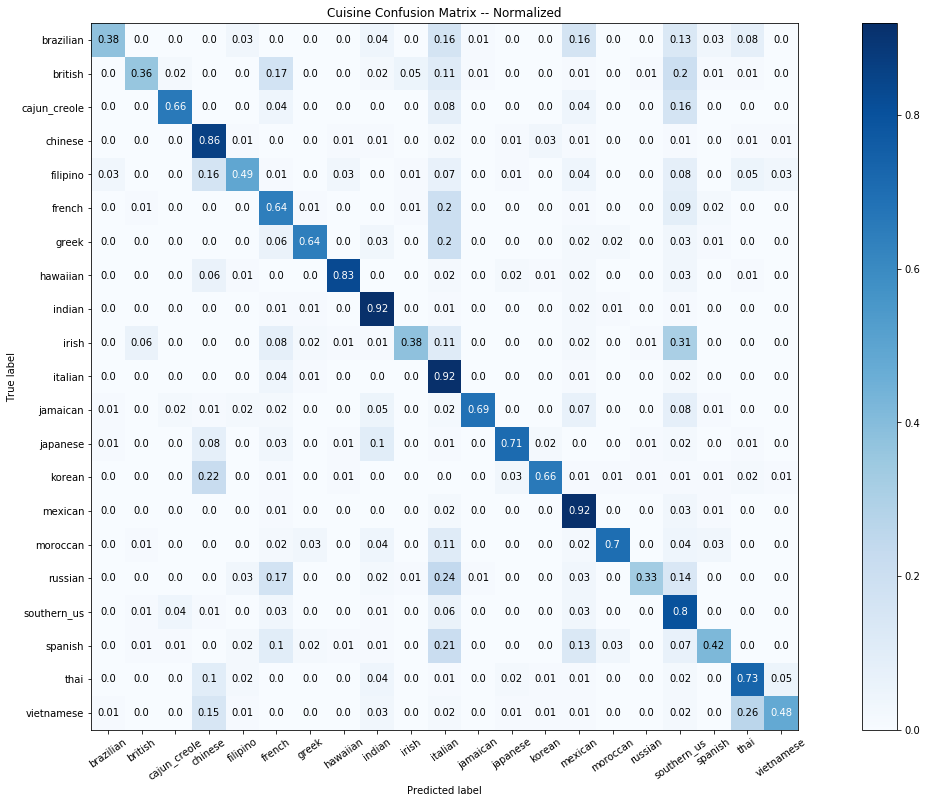

In [22]:
#constructing confusion matrix to understand the knn model better
#confused_data = confusion_matrix(y_test, logit.predict(X_test))
#confused_data
skplt.metrics.plot_confusion_matrix(y_test, logit.predict(X_test), normalize=True, figsize = (23,13));

target_names = labeler.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=35)
plt.yticks(tick_marks, target_names)

plt.title('Cuisine Confusion Matrix -- Normalized');

plt.savefig("oldermodel.png")

## Interesting Insight
English breakfast style breakfasts are very common and popular in the South's fry up culture. That is why English and Irish Foods are commonly misclassified as Southern US food. Misclassifcations as a possible way to recommend other cuisines to people since many misclassifcations are caused by interactions through culture across history.

#we_learn_more_from_our_mistakes_than_our_successes

In [23]:
#NaiveBayes
nb = MultinomialNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(classification_report(y_test,y_pred, target_names = target_names))

              precision    recall  f1-score   support

   brazilian       0.92      0.14      0.25        77
     british       0.90      0.06      0.11       152
cajun_creole       0.84      0.46      0.60       310
     chinese       0.54      0.92      0.68       517
    filipino       0.90      0.07      0.12       138
      french       0.57      0.42      0.48       548
       greek       0.90      0.32      0.47       233
    hawaiian       0.95      0.28      0.43       189
      indian       0.76      0.90      0.83       602
       irish       1.00      0.08      0.14       133
     italian       0.63      0.90      0.75      1559
    jamaican       1.00      0.14      0.25       120
    japanese       0.91      0.56      0.69       278
      korean       0.93      0.32      0.48       166
     mexican       0.79      0.91      0.85      1301
    moroccan       0.94      0.33      0.49       136
     russian       0.00      0.00      0.00        90
 southern_us       0.50    

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
#DTC
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   brazilian       0.41      0.42      0.41        77
     british       0.27      0.26      0.26       152
cajun_creole       0.57      0.53      0.55       310
     chinese       0.62      0.65      0.64       517
    filipino       0.40      0.42      0.41       138
      french       0.43      0.44      0.43       548
       greek       0.56      0.55      0.55       233
    hawaiian       0.78      0.70      0.74       189
      indian       0.74      0.75      0.74       602
       irish       0.29      0.26      0.28       133
     italian       0.75      0.75      0.75      1559
    jamaican       0.72      0.53      0.61       120
    japanese       0.58      0.60      0.59       278
      korean       0.54      0.55      0.55       166
     mexican       0.80      0.81      0.80      1301
    moroccan       0.37      0.40      0.38       136
     russian       0.24      0.19      0.21        90
 southern_us       0.54    

In [25]:
#RTC
rtc = RandomForestClassifier()
rtc.fit(X_train,y_train)
rtc.score(X_test,y_test)
y_pred = rtc.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

   brazilian       0.62      0.34      0.44        77
     british       0.37      0.29      0.32       152
cajun_creole       0.64      0.59      0.61       310
     chinese       0.59      0.83      0.69       517
    filipino       0.53      0.39      0.45       138
      french       0.50      0.53      0.51       548
       greek       0.71      0.47      0.57       233
    hawaiian       0.75      0.55      0.63       189
      indian       0.77      0.89      0.82       602
       irish       0.56      0.26      0.36       133
     italian       0.70      0.87      0.77      1559
    jamaican       0.89      0.42      0.57       120
    japanese       0.75      0.60      0.67       278
      korean       0.79      0.51      0.62       166
     mexican       0.80      0.89      0.84      1301
    moroccan       0.70      0.53      0.60       136
     russian       0.59      0.18      0.27        90
 southern_us       0.66    

# 7. Addressing Class Imbalances and Additional Model Training

In [26]:
#So far logistic regression performs the best. #adding class weights and testing different solvers
#multiclass lowered accuracy, but got more precision
lr_multi = LogisticRegression(class_weight='balanced', solver='lbfgs')
lr_multi.fit(X_train, y_train)
y_pred = lr_multi.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

   brazilian       0.43      0.58      0.50        77
     british       0.42      0.55      0.47       152
cajun_creole       0.73      0.73      0.73       310
     chinese       0.78      0.79      0.79       517
    filipino       0.52      0.62      0.57       138
      french       0.58      0.65      0.62       548
       greek       0.70      0.77      0.73       233
    hawaiian       0.84      0.87      0.85       189
      indian       0.89      0.88      0.88       602
       irish       0.46      0.51      0.48       133
     italian       0.89      0.81      0.85      1559
    jamaican       0.75      0.77      0.76       120
    japanese       0.83      0.74      0.79       278
      korean       0.70      0.75      0.72       166
     mexican       0.94      0.87      0.91      1301
    moroccan       0.67      0.82      0.74       136
     russian       0.38      0.54      0.45        90
 southern_us       0.79    

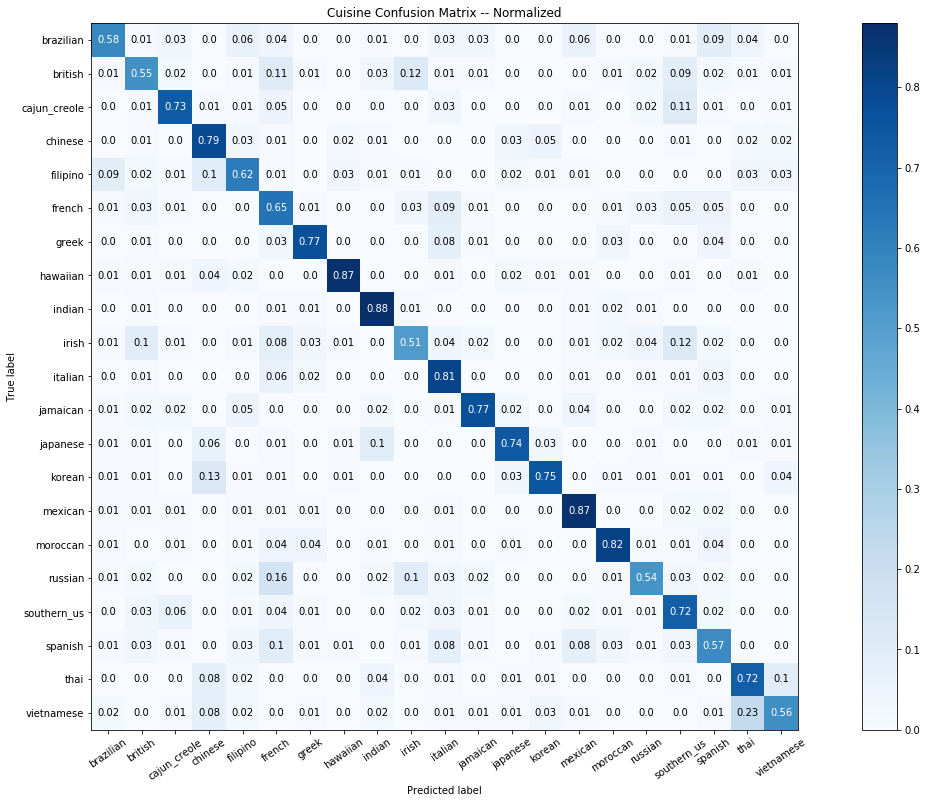

In [27]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize = (23,13));

target_names = labeler.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=35)
plt.yticks(tick_marks, target_names)

plt.title('Cuisine Confusion Matrix -- Normalized');

In [28]:
#so far logistic regression performs the best. #adding class weights and testing different solvers
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_balanced.fit(X_train, y_train)
y_pred = lr_balanced.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

#Balanced weighting did not yield very good results, will adjust to an intermediate scoring and a multiclass solver

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

   brazilian       0.47      0.64      0.54        77
     british       0.39      0.57      0.47       152
cajun_creole       0.71      0.73      0.72       310
     chinese       0.79      0.82      0.81       517
    filipino       0.53      0.65      0.58       138
      french       0.59      0.63      0.61       548
       greek       0.72      0.76      0.74       233
    hawaiian       0.82      0.88      0.85       189
      indian       0.89      0.87      0.88       602
       irish       0.50      0.53      0.51       133
     italian       0.88      0.80      0.84      1559
    jamaican       0.70      0.81      0.75       120
    japanese       0.85      0.74      0.79       278
      korean       0.70      0.77      0.73       166
     mexican       0.94      0.87      0.90      1301
    moroccan       0.63      0.85      0.72       136
     russian       0.35      0.58      0.43        90
 southern_us       0.77    

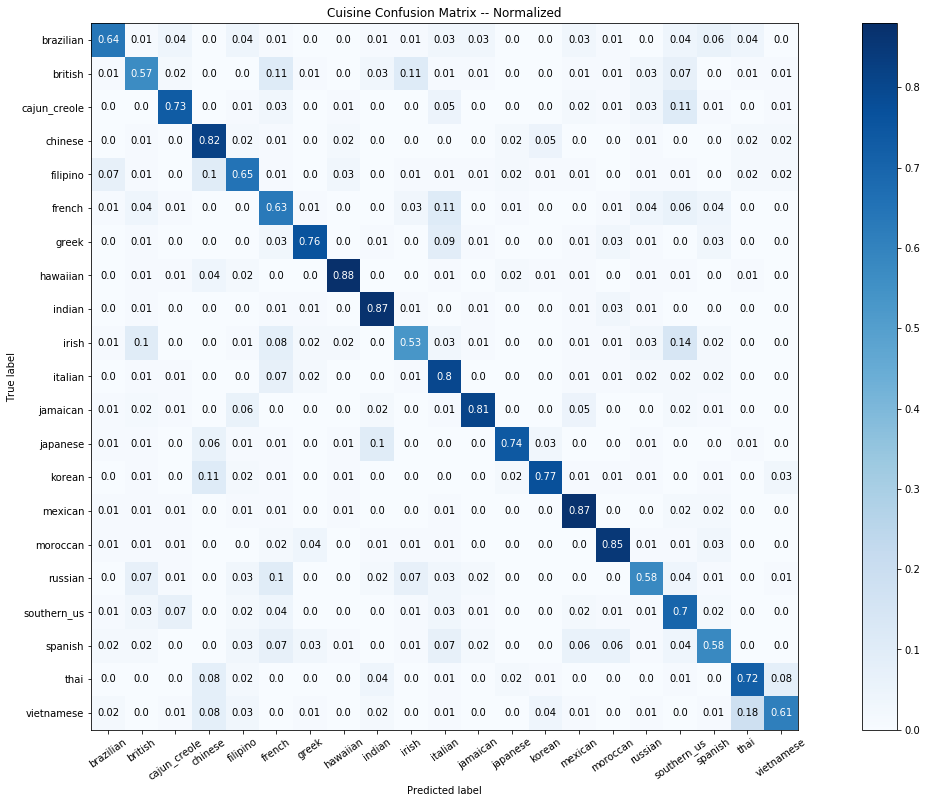

In [29]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize = (23,13));

target_names = labeler.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=35)
plt.yticks(tick_marks, target_names)

plt.title('Cuisine Confusion Matrix -- Normalized');

In [30]:
#So far logistic regression performs the best. #adding class weights and testing different solvers
lr_balanced = LogisticRegression(class_weight='balanced', solver='newton-cg')
lr_balanced.fit(X_train, y_train)
y_pred = lr_balanced.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

#Balanced weighting did not yield very good results, will adjust to an intermediate scoring and a multiclass solver

              precision    recall  f1-score   support

   brazilian       0.43      0.58      0.50        77
     british       0.42      0.55      0.47       152
cajun_creole       0.73      0.73      0.73       310
     chinese       0.78      0.79      0.79       517
    filipino       0.52      0.62      0.57       138
      french       0.58      0.65      0.62       548
       greek       0.70      0.77      0.73       233
    hawaiian       0.84      0.87      0.85       189
      indian       0.89      0.88      0.88       602
       irish       0.46      0.51      0.48       133
     italian       0.89      0.81      0.85      1559
    jamaican       0.75      0.77      0.76       120
    japanese       0.83      0.74      0.79       278
      korean       0.70      0.75      0.72       166
     mexican       0.94      0.87      0.91      1301
    moroccan       0.67      0.82      0.74       136
     russian       0.38      0.54      0.45        90
 southern_us       0.79    

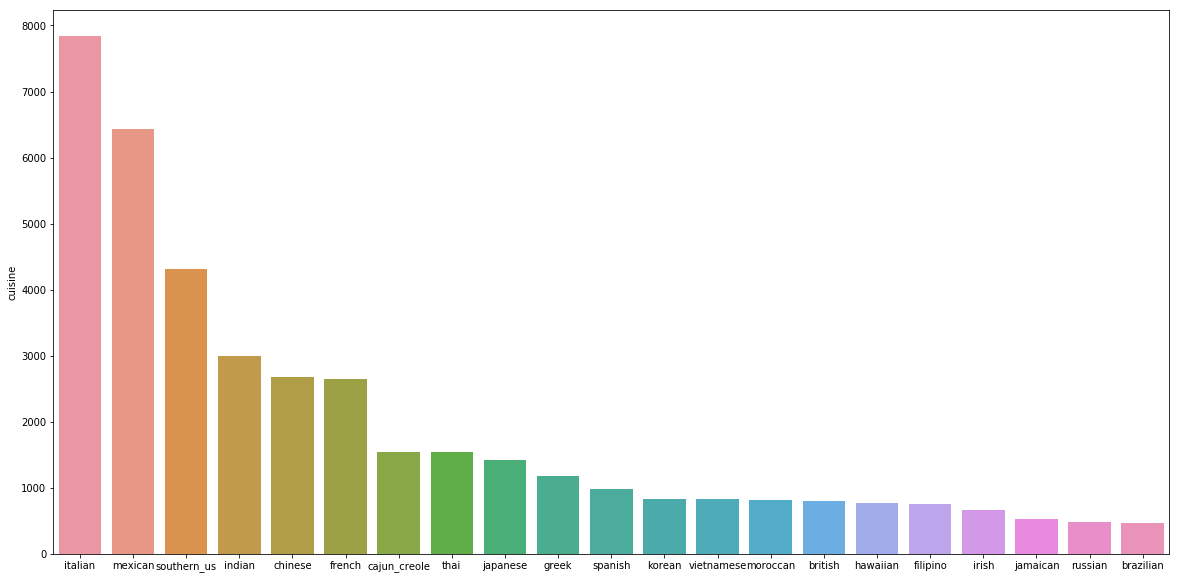

In [31]:
#Using a intermediate weighting system:
df_count_cuisine = pd.DataFrame(df_newtest.cuisine.value_counts())
plt.figure(figsize = (20,10))
sns.barplot(x = df_count_cuisine.index, y = df_count_cuisine.cuisine);

In [32]:
cuisine_quicklist = pd.DataFrame(labeler.classes_, columns = ['Cuisine'])
cuisine_quicklist

,Cuisine
0,brazilian
1,british
2,cajun_creole
3,chinese
4,filipino
5,french
6,greek
7,hawaiian
8,indian
9,irish


In [33]:
#weight dictionary:
base = 1
low = 2
medium = 3
high = 5
weights = {0:high,1:high,2:high,3:medium,4:high,5:low,6:medium,7:high, 8:low, 9:high, 10:base, 11:high, 12: medium, 
           13: medium, 14:1, 15:medium, 16:high,17:base, 18: medium, 19: medium, 20: high}

In [34]:
#The custom weights raised the accuracy and overally other metrics much higher
#this rest was with custom weights and liblinear, will try using a multiclass solver
logit_customweights = LogisticRegression(C = 5 , class_weight=weights, solver='liblinear')
logit_customweights.fit(X_train, y_train)

y_pred = logit_customweights.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

   brazilian       0.56      0.57      0.57        77
     british       0.43      0.57      0.49       152
cajun_creole       0.69      0.75      0.72       310
     chinese       0.74      0.85      0.79       517
    filipino       0.57      0.64      0.60       138
      french       0.59      0.66      0.63       548
       greek       0.74      0.74      0.74       233
    hawaiian       0.87      0.85      0.86       189
      indian       0.88      0.89      0.88       602
       irish       0.50      0.48      0.49       133
     italian       0.86      0.86      0.86      1559
    jamaican       0.82      0.75      0.78       120
    japanese       0.81      0.75      0.78       278
      korean       0.79      0.69      0.74       166
     mexican       0.93      0.90      0.91      1301
    moroccan       0.74      0.81      0.77       136
     russian       0.49      0.53      0.51        90
 southern_us       0.82    

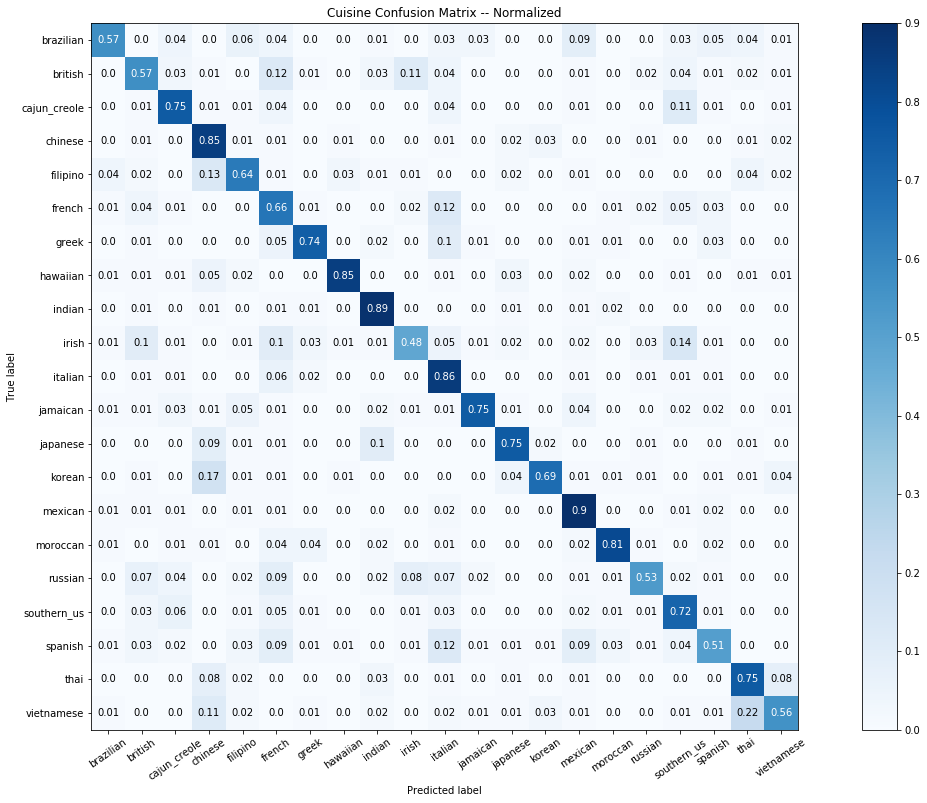

In [35]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize = (23,13));

target_names = labeler.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=35)
plt.yticks(tick_marks, target_names)

plt.title('Cuisine Confusion Matrix -- Normalized');

plt.savefig("test.png")

In [36]:
#The custom weights raised the accuracy and overally other metrics much higher
#this rest was with custom weights and liblinear, will try using a multiclass solver
logit_customweights = LogisticRegression(class_weight=weights,multi_class= 'auto', solver='newton-cg')
logit_customweights.fit(X_train, y_train)

y_pred = logit_customweights.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   brazilian       0.53      0.60      0.56        77
     british       0.38      0.61      0.47       152
cajun_creole       0.63      0.80      0.71       310
     chinese       0.75      0.85      0.80       517
    filipino       0.53      0.64      0.58       138
      french       0.58      0.66      0.62       548
       greek       0.74      0.75      0.75       233
    hawaiian       0.84      0.86      0.85       189
      indian       0.87      0.88      0.87       602
       irish       0.49      0.55      0.52       133
     italian       0.87      0.83      0.85      1559
    jamaican       0.82      0.78      0.80       120
    japanese       0.82      0.74      0.78       278
      korean       0.77      0.71      0.74       166
     mexican       0.94      0.87      0.90      1301
    moroccan       0.69      0.81      0.74       136
     russian       0.45      0.56      0.50        90
 southern_us       0.83    

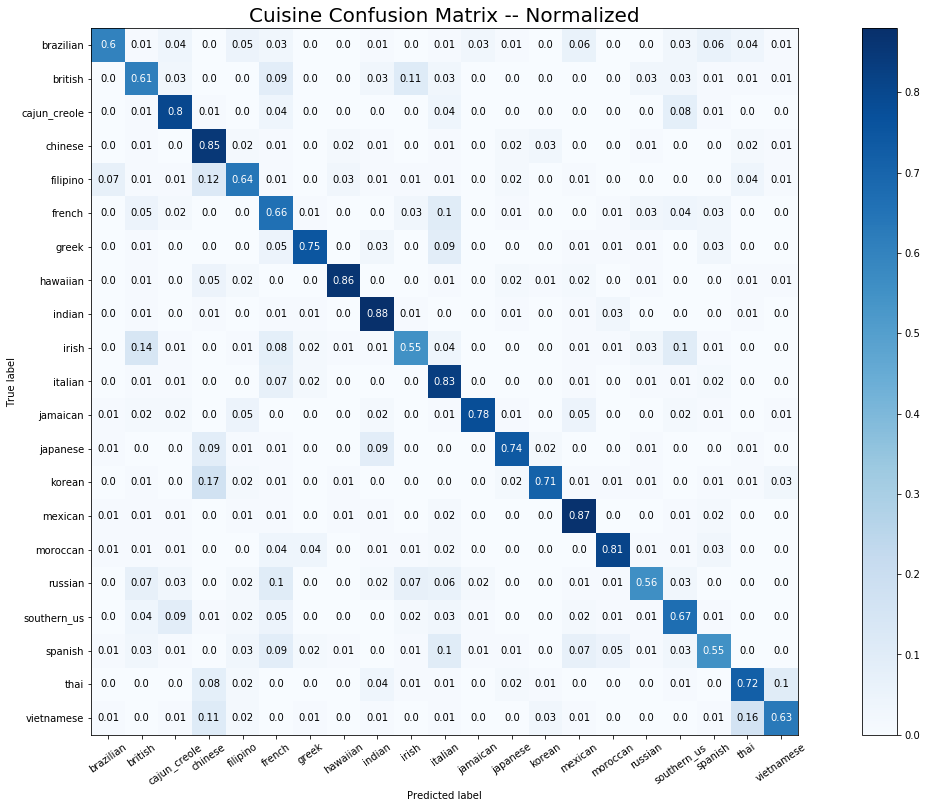

In [37]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize = (23,13));

target_names = labeler.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=35)
plt.yticks(tick_marks, target_names)

plt.title('Cuisine Confusion Matrix -- Normalized', fontsize = 20);

## Results so far
So far Logistic Regression (One Vs Rest) with custom weighted classes produced the best results. </b>

79%-80% for all major metrics before cross validation 

# 6. Gradient Boosted Trees WIP

In [38]:
#splitting data for evaluation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

X_train

<24330x3079 sparse matrix of type '<class 'numpy.float64'>'
	with 459113 stored elements in Compressed Sparse Row format>

In [39]:
'''gbm = xgb.XGBRegressor(
    n_estimators=30000,  #arbitrary large number
    max_depth=10,
    objective="multi:softprob",
    learning_rate=.02,
    subsample=.8,
    min_child_weight=8,
    colsample_bytree=.7,
    n_jobs=-1,
    random_state=0,
    num_class = 21
)

eval_set = [(X_train, y_train),
            (X_val, y_val)]  #tracking train/validation error as we go
fit_model = gbm.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='merror',
    early_stopping_rounds=50, #this parameter stops the fitting if the score doesn't improve after 50 tries
    verbose=False)'''

'gbm = xgb.XGBRegressor(\n    n_estimators=30000,  #arbitrary large number\n    max_depth=10,\n    objective="multi:softprob",\n    learning_rate=.02,\n    subsample=.8,\n    min_child_weight=8,\n    colsample_bytree=.7,\n    n_jobs=-1,\n    random_state=0,\n    num_class = 21\n)\n\neval_set = [(X_train, y_train),\n            (X_val, y_val)]  #tracking train/validation error as we go\nfit_model = gbm.fit(\n    X_train,\n    y_train,\n    eval_set=eval_set,\n    eval_metric=\'merror\',\n    early_stopping_rounds=50, #this parameter stops the fitting if the score doesn\'t improve after 50 tries\n    verbose=False)'

In [40]:
#print(classification_report(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit), y_val, target_names = target_names))
#yprob = gbm.predict( X_test ).reshape( y_test.shape[0], 21)


In [41]:
#y_pred = np.argmax(yprob, axis=1)

In [42]:
#print(classification_report(y_test, y_pred, target_names = target_names))

#previous models are producing better results, this model takes 15 min to run as well

# 7. Conducting Analysis and Crossvalidation on Models

In [43]:
#Get more promising models and test again using CV
#Logistic Regresssion (One Vs Rest) vs Logsitic Regression (Multi) vs MultiNB and DTC with weights
logit_customweights = LogisticRegressionCV(class_weight=weights, solver='liblinear', cv = 5,scoring = 'accuracy')
logit_customweights.fit(X_train, y_train)

y_pred = logit_customweights.predict(X_test)
print(classification_report(y_test, y_pred, target_names = target_names))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

   brazilian       0.50      0.58      0.54        77
     british       0.46      0.58      0.51       152
cajun_creole       0.63      0.78      0.70       310
     chinese       0.74      0.85      0.79       517
    filipino       0.56      0.62      0.59       138
      french       0.59      0.68      0.63       548
       greek       0.71      0.74      0.73       233
    hawaiian       0.85      0.86      0.86       189
      indian       0.87      0.88      0.88       602
       irish       0.54      0.53      0.53       133
     italian       0.87      0.82      0.84      1559
    jamaican       0.75      0.77      0.76       120
    japanese       0.80      0.73      0.76       278
      korean       0.78      0.68      0.73       166
     mexican       0.92      0.89      0.90      1301
    moroccan       0.69      0.76      0.73       136
     russian       0.51      0.48      0.49        90
 southern_us       0.79    

In [44]:
cross_val_score(logit_customweights, X_test, y_test, # estimator, features, target
                cv=5, # number of folds 
                scoring='accuracy').mean()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linea

0.6973624696662877

In [45]:
sorted(skl.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

# 8. Generating Visualizations and Additional EDA


In [46]:
#Top Ingredients per cuisine
#Unique Ingredients Per Cuisine
#Two Simliar Cuisines
#Alot of food pictures

#create a new data frame that aggregates all the ingredients together and groupsby cuisine
df_cuisine = df_newtest.groupby(['cuisine'])['nlp_ingredients'].apply(','.join).reset_index()
df_cuisine.head()

In [47]:
#create a function that takes in a dataframe and returns a dataframe with all ingredient counts
#successful function
def makeingcountdf(dataframe):
    #initialize countvectorizer
    ingcount = CountVectorizer()
    frequency= ingcount.fit_transform(dataframe['nlp_ingredients'])
    
    #create dataframe from sparse matrix
    counts = pd.DataFrame(frequency.toarray(), columns = ingcount.get_feature_names())
    
    #sums all ingredients
    count_list =[]
    for ingredients in counts.columns:
        count_list.append(counts[ingredients].sum())
        
    #creates data frame
    count_ingredients = pd.DataFrame([ingcount.get_feature_names(),count_list]).transpose()
    final_df = count_ingredients.rename(columns={0:'Ingredient', 1: 'Count'})
    #return dataframe
    return final_df

In [48]:
#create a function that create a distribution of most common ingredients

def topingredients(cuisine, n = 20):
    df_cuisine = df_newtest[df_newtest.cuisine == cuisine]
    return makeingcountdf(df_cuisine).sort_values(by = 'Count', ascending = False).head(n)
    

In [49]:
irish=topingredients('irish')
irish.head()

,Ingredient,Count
558,salt,459
244,flour,341
77,butter,335
644,sugar,304
456,pepper,282


<BarContainer object of 20 artists>

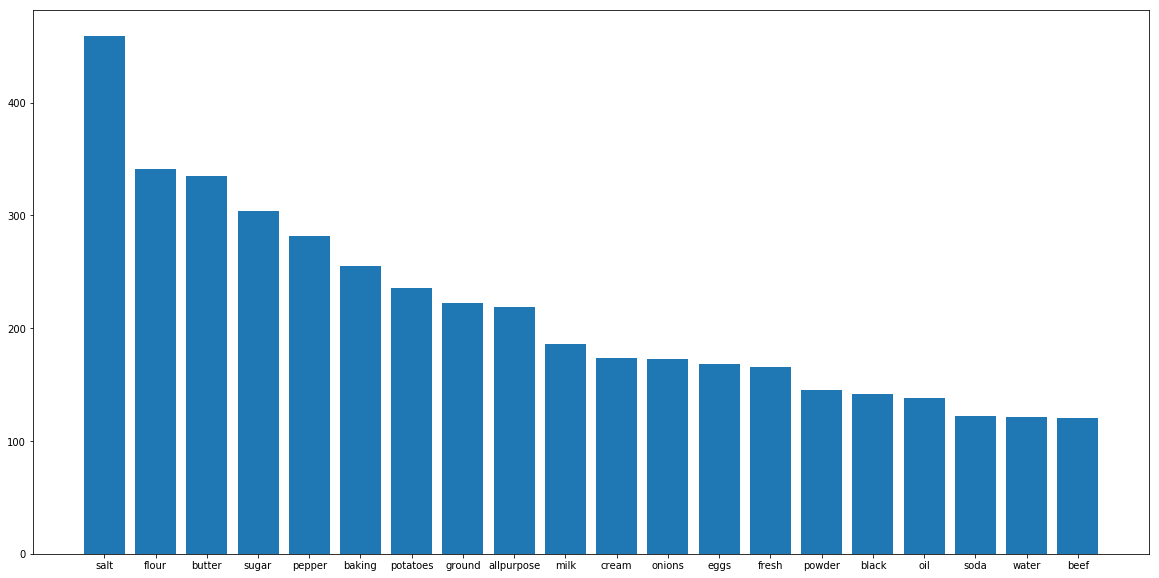

In [50]:
plt.figure(figsize = (20,10))
plt.bar(irish.Ingredient,irish.Count)

In [51]:
ingredient_coef = pd.DataFrame(logit_customweights.coef_,index = target_names, columns = vectorize.get_feature_names() )

In [52]:
ingredient_coef = ingredient_coef.transpose() #Dataframe of cuisines and the coefficients of ingredients

ingredient_coef.head()

#send to csv for tableau analysis

ingredient_coef.to_csv('ingredient_cuisine.csv')

In [53]:
japan = ingredient_coef['japanese']

japan.sort_values(ascending = False)[0:10]

mirin       10.078386
miso         9.841186
udon         9.774400
sake         9.162461
soba         8.731938
dashi        7.614788
mochiko      7.237236
tonkatsu     6.839949
teriyaki     6.643000
bonito       6.629159
Name: japanese, dtype: float64

In [54]:
#write function that returns the ingredients with the largest coefficients
#this will basically be a proxy for the most defining ingredients in a cuisine
#can be used to identify the authenticity of a restaurant, dish, or etc

def signature_ingredients(cuisine, n=10):
    #create ingredient coefficient dataframe
    ingredient_coef = pd.DataFrame(logit_customweights.coef_,index = target_names, columns = vectorize.get_feature_names() )
    #transpose
    ingredient_coef = ingredient_coef.transpose()
    #return series with top ingredients and coefficients
    df = pd.DataFrame(ingredient_coef[cuisine]).reset_index()
    df = df.rename(columns={'index': 'ingredient', cuisine: 'coef'})
    
    df = df.sort_values(by = 'coef', ascending = False)
    return df.head(n)

In [55]:
signature_ingredients('hawaiian',10)

,ingredient,coef
2104,pineapple,19.351765
1692,mayonnaise,6.452266
1273,hawaiian,5.944664
1308,highgluten,5.928445
1311,himalayan,5.913161
2105,pineapples,5.219706
1912,onion,5.059460
2615,spam,4.830302
2891,turbinado,4.829944
20,ahi,4.531540


In [56]:
p = logit_customweights.predict_proba(vectorize.transform(['rice salmon']))[0]
p

array([3.42160822e-03, 1.69496392e-02, 3.40927433e-02, 1.65227588e-02,
       5.15187573e-02, 7.63212816e-03, 4.38139928e-04, 3.07005347e-02,
       2.29175273e-02, 1.50219351e-02, 1.14612223e-02, 8.34736640e-04,
       7.12749794e-01, 1.00473628e-03, 7.91493884e-05, 2.72551485e-04,
       2.00453643e-02, 1.79160569e-03, 3.26198699e-03, 2.52119906e-02,
       2.40710904e-02])

In [57]:
np.argsort(p)[::-1][:3]

array([12,  4,  2])

# 9. Predicting Cuisines and Providing Cultural Breakdown

In [58]:
#make function that creates dataframe based on results of predict_cuisine
#two arrays

def cuisine_breakdown(top3,top_prob):
    
    df = pd.DataFrame({ 'cuisine':top3,'percentage':top_prob})
    
    #replace cuisine number with cuisine name
    d = cuisine_quicklist.to_dict()
    d= d['Cuisine']
    df["cuisine"] = df["cuisine"].map(d) #map dictionary values of cuisine names back to the df
    return df

In [59]:
#write function that takes in a list of ingredients and predicts its cuisine
#returns top n cuisines and the probability 

def predict_cuisine(ingredients):
    #vectorize ingredients
    X_ing = vectorize.transform(ingredients)
    
#     y_pred = logit_customweights.predict(X_ing)
    prob = logit_customweights.predict_proba(X_ing)[0]
    top3 = np.argsort(prob)[::-1][:3]
    top_prob = np.sort(prob)[::-1][:3]

    return cuisine_breakdown(top3,top_prob)
    

In [60]:
#weeee it works type in string of ingredients and it will predict its cuisine
predict_cuisine(['tortilla rice pork kimchi avocado scallions pico de gallo gochujang queso fresco lime pork oil soy sauce sugar mirin sesame garlic onion ginger yogurt'])

,cuisine,percentage
0,korean,0.920244
1,mexican,0.029588
2,vietnamese,0.014730


In [61]:
#type in string of ingredients and it will predict its cuisine
predict_cuisine(['rice spam'])

,cuisine,percentage
0,hawaiian,0.237163
1,filipino,0.230205
2,cajun_creole,0.083686


# 10. Exporting Visualizations CSVs

In [62]:
'''
#create a for loop that creates csvs of top ingredients and signature ingredients (can be one each)

#top ingredients loop
#loop through each cuisine

for cuisine in target_names:
    df = topingredients(cuisine, 20)
    df.to_csv('{}_top_ing.csv'.format(cuisine))
#utilize functions
#export csv
#Successfully ran
'''

"\n#create a for loop that creates csvs of top ingredients and signature ingredients (can be one each)\n\n#top ingredients loop\n#loop through each cuisine\n\nfor cuisine in target_names:\n    df = topingredients(cuisine, 20)\n    df.to_csv('{}_top_ing.csv'.format(cuisine))\n#utilize functions\n#export csv\n#Successfully ran\n"

In [63]:
'''#signature ingredients loop
#loop through each cuisine
#utilize functions
#export csv


for cuisine in target_names:
    df = signature_ingredients(cuisine, 20)
    df.to_csv('{}_signature_ing.csv'.format(cuisine))
    
#Successfully ran
'''

"#signature ingredients loop\n#loop through each cuisine\n#utilize functions\n#export csv\n\n\nfor cuisine in target_names:\n    df = signature_ingredients(cuisine, 20)\n    df.to_csv('{}_signature_ing.csv'.format(cuisine))\n    \n#Successfully ran\n"